In [ ]:
from model_drift import settings

from model_drift.stats import calc_p_categorical, calc_p_real, calculate_alerts
from model_drift.helpers import prepare_padchest
import matplotlib.pylab as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


# Real Valued Number Drift Detection

In [ ]:
# Load padchest CSV
padchest_csv = settings.PADCHEST_FILENAME
df = pd.read_csv(padchest_csv)
df = prepare_padchest(df)



In [20]:
from scipy.stats import ks_2samp
from scipy import stats

def calc_p_real(train, test):
    if len(test):
        return ks_2samp(train, test)[0]
    return None


alphas = {
    100: 1.22,
    50: 1.36,
    25: 1.48,
    10: 1.63,
    5: 1.73,
    1: 1.95
}

def calc_critical_value(n1, n2, alpha=100):
    if n2 == 0:
        return None
    ca = alphas[alpha]
    return ca*np.sqrt((n1+n2)/(n1*n2))



In [101]:
# Add an "age" and "image size column"``
df['age'] = (df["StudyDate"]-df['PatientBirth']) / np.timedelta64(1, 'Y')
df['image_size'] = df['Rows_DICOM']*df['Columns_DICOM']

# Define graph constants
freq = "30d"
resolution = '5d'
col = 'age'
split_date = "2014-01-01"
ks_threshold = 0.2

# Enure that column is a numeric value
df[col] = pd.to_numeric(df[col], errors='coerce')

# Set index and split dataframe
df = df.set_index('StudyDate', drop=False).sort_index()
df_ref = df.loc[(df.index < split_date)]
df_target = df[(df.index >= split_date)]

# Calculate stats on refernce points
m = df_ref[col].mean()
std = df_ref[col].std()
nobs = len(df_ref)

# Calculate rolling stats on target points
df_roll = df_target.rolling(freq)[col].mean().resample('1d').mean()

df_roll.index = map(lambda x: x.date(), df_roll.index.to_list())
# Find outliers in the target data


# Define overlay area
dfmean = pd.DataFrame([(df_roll.index.min(), m), (df_roll.index.max(), m)], columns=[
                      'StudyDate', col]).set_index("StudyDate")
dfstd = pd.DataFrame([(df_roll.index.min(), std/3, -std/3), (df_roll.index.max(),
                     std/3, -std/3), ], columns=['StudyDate', 'H', 'L']).set_index("StudyDate")


# Calculate mean rolling pvalue with stats calcuated at some resolution
df_roll_p = df_target[col].resample(resolution).apply(
    lambda x: calc_p_real(df_ref[col], x))
df_roll_crit = df_target[col].resample(resolution).apply(
    lambda x: calc_critical_value(len(df_ref), len(x), alpha=5))


is_drift = (df_roll_p-df_roll_crit)
is_drift.index = map(lambda x: x.date(), is_drift.index.to_list())


In [261]:
import tqdm
def calc_critical_value(n1, n2, alpha=100):
    n1 = min(10000, n1)
    n2 = min(10000, n2)
    if n2 == 0:
        return None
    ca = alphas[alpha]
    return ca * np.sqrt((n1 + n2) / (n1 * n2))

alphas = {
    100: 1.22,
    50: 1.36,
    25: 1.48,
    10: 1.63,
    5: 1.73,
    1: 1.95
}

def calc_p_real2(train, test):
    if len(test):
        return ks_2samp(train, test, mode='asymp')
    return None, None

dfx = df_target[col].resample("1d").apply(list)
N = 90
new_df = []
save = []
for i in tqdm.tqdm_notebook(range(N, len(dfx)), total=len(dfx)-N):
    x = sum(dfx.iloc[i: i + N].values, [])
    ks, p = calc_p_real2(df_ref[col], x)
    d =  {"StudyDate": dfx.index.values[i], "mean": np.mean(x), "p": p, "stat": ks,}
    for a in alphas.keys():
        d[f'crit_{a}'] = calc_critical_value(len(df_ref), len(x), alpha=a)
    if  d['stat']-d['crit_1'] < 0:
        save.append(x)
    new_df.append(d)
new_df = pd.DataFrame(new_df).set_index('StudyDate')
new_df.index = map(lambda x: x.date(), new_df.index.to_list())


  0%|          | 0/1327 [00:00<?, ?it/s]

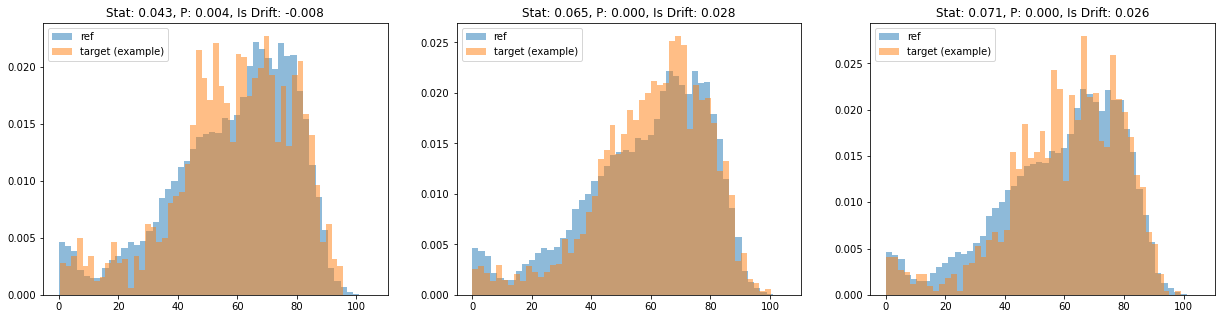

In [270]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7*3, 5))

i = 438-90
target = sum(dfx.iloc[i: i + N].values, [])
target = save[10]

stat, p = ks_2samp(df_ref[col], target)
crit = calc_critical_value(len(df_ref), len(target), alpha=1)

is_drift_ = stat-crit

ax1.set_title(f"Stat: {stat:.3f}, P: {p:.3f}, Is Drift: {is_drift_:.3f}")
ax1.hist(df_ref[col], alpha=0.5, label='ref', density=True, bins=50)
ax1.hist(target, alpha=.5, label='target (example)', density=True, bins=50)
ax1.legend()


i = 438-90
target = sum(dfx.iloc[i: i + N].values, [])
stat, p = ks_2samp(df_ref[col], target)
crit = calc_critical_value(len(df_ref), len(target), alpha=1)

is_drift_ = stat-crit
ax2.set_title(f"Stat: {stat:.3f}, P: {p:.3f}, Is Drift: {is_drift_:.3f}")
ax2.hist(df_ref[col], alpha=0.5, label='ref', density=True, bins=50)
ax2.hist(target, alpha=.5, label='target (example)', density=True, bins=50)
ax2.legend()


i = 0
target = sum(dfx.iloc[i: i + N].values, [])
stat, p = ks_2samp(df_ref[col], target)
crit = calc_critical_value(len(df_ref), len(target), alpha=1)

is_drift_ = stat-crit
ax3.set_title(f"Stat: {stat:.3f}, P: {p:.3f}, Is Drift: {is_drift_:.3f}")
ax3.hist(df_ref[col], alpha=0.5, label='ref', density=True, bins=50)
ax3.hist(target, alpha=.5, label='target (example)', density=True, bins=50)
ax3.legend()

In [247]:
# from scipy import stats
# def calc_p_realt(mean1, std1, nobs1, mean2, std2, nobs2):
#     if nobs2 > 0:
#         return stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2, equal_var=True)[1]
#     return None


# df_roll_ = df_target.rolling(freq)[col].agg(['mean', 'std', 'count'])

# df_roll_.head()

# df_roll_t = df_roll_[["mean", "std", "count"]].apply(lambda x: calc_p_realt(m, std, nobs, x["mean"], x["std"], x["count"]), axis=1)
# df_roll_t.sample(100)

## Plot Real Valued Graph

In [248]:


dfmean = pd.DataFrame([(dfx.index.min(), m), (dfx.index.max(), m)], columns=[
                      'StudyDate', col]).set_index("StudyDate")
dfstd = pd.DataFrame([(dfx.index.min(), std/3, -std/3), (dfx.index.max(),
                     std/3, -std/3), ], columns=['StudyDate', 'H', 'L']).set_index("StudyDate")

alerts = []
alerts += calculate_alerts(new_df['mean'], new_df['mean'] < (m - std/3))
alerts += calculate_alerts(new_df['mean'], new_df['mean'] > (m + std/3))

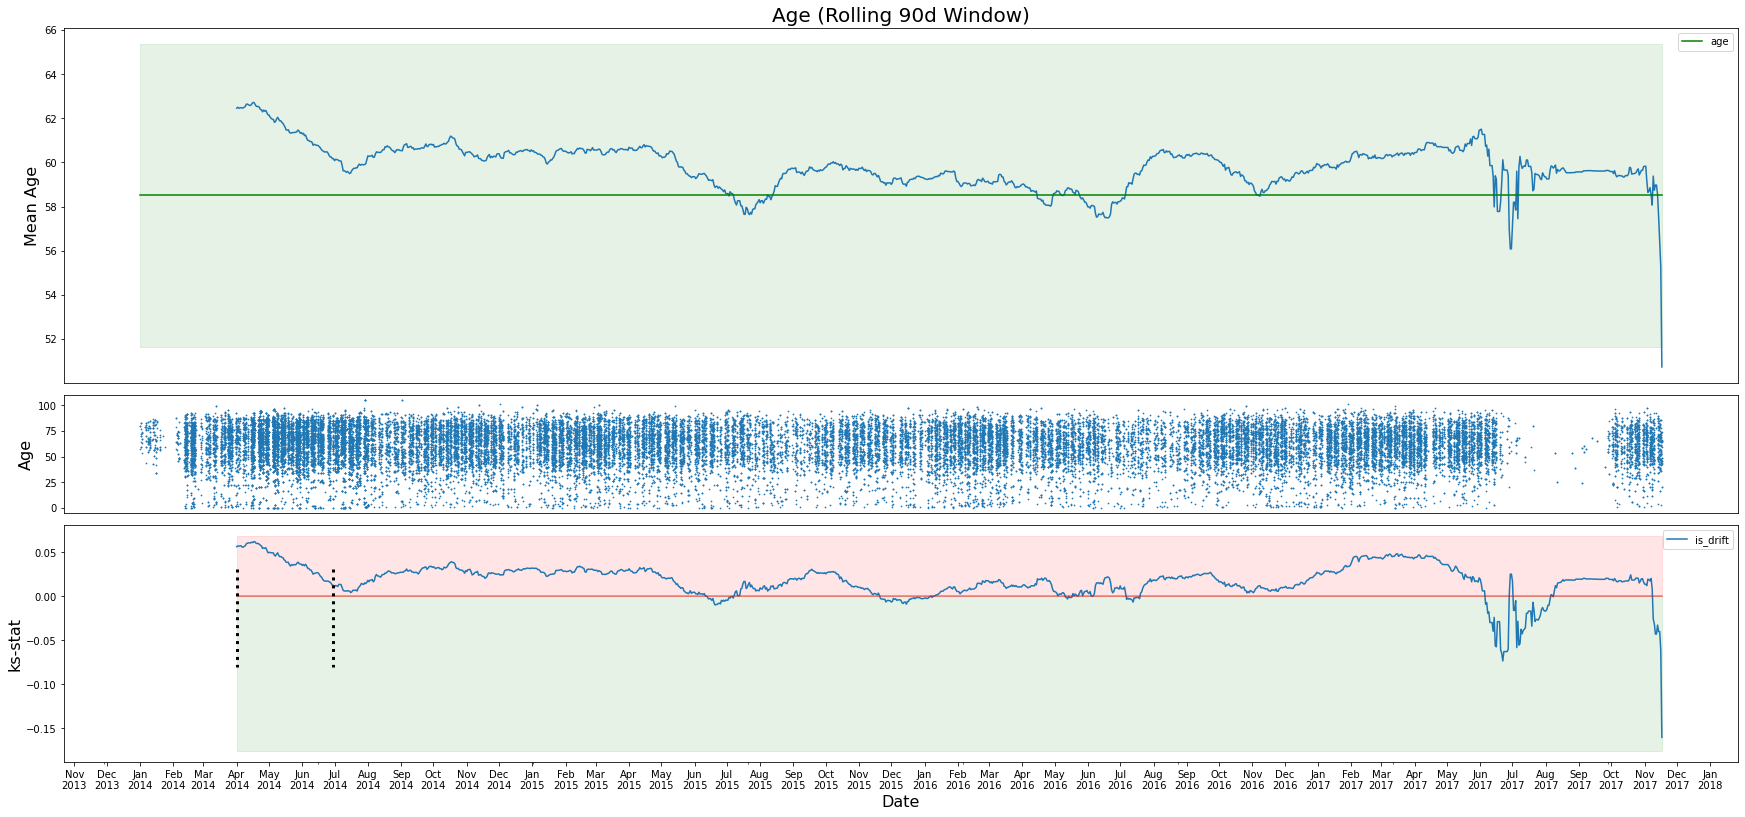

In [250]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(
    30, 15), sharex=True, gridspec_kw={'height_ratios': [15, 5, 10], 'wspace':0, 'hspace':.05})


new_df['mean'].plot(ax=axes[0], label='Age')
dfmean.plot(ax=axes[0], color='green')
axes[0].fill_between(dfstd.index, m+dfstd['H'], m +
                     dfstd['L'], 3, color='green', alpha=.1)
for dfalert in alerts:
    _ = axes[0].fill_between(dfalert.index, dfalert['h'],
                             dfalert['l'], 3, color='red', alpha=.25)

axes[1].scatter(df_target.index.tolist(), df_target[col], marker='.', s=2)


alpha = 1
new_df['is_drift'] = new_df['stat']-new_df[f'crit_{alpha}']

# df_roll_p.plot(ax=axes[-1], label="ks-stat")
# df_roll_crit.plot(ax=axes[-1], label='critical')
new_df['is_drift'].plot(ax=axes[-1])
# df_roll_p2.plot(ax=axes[-1], label=calc_p_real2.name)
# df_roll_t.plot(ax=axes[-1], label="t")

axes[-1].plot([new_df.index.min(), new_df.index.max()], [0, 0], 'r', alpha=.5)
axes[-1].fill_between([new_df.index.min(), new_df.index.max()], [new_df['is_drift'].min()*1.1, new_df['is_drift'].min()*1.1], [0, 0], 3, color='green', alpha=.1)
axes[-1].fill_between([new_df.index.min(), new_df.index.max()], [0, 0], [new_df['is_drift'].max()*1.1, new_df['is_drift'].max()*1.1], 3, color='red', alpha=.1)

from datetime import timedelta

axes[-1].plot([new_df.index.min(), new_df.index.min()], [new_df['is_drift'].max()*0.5, new_df['is_drift'].min()*0.5], ':k', alpha=1, linewidth=3)
axes[-1].plot([new_df.index.min()+timedelta(days=N), new_df.index.min()+timedelta(days=N)], [new_df['is_drift'].max()*.5, new_df['is_drift'].min()*.5], ':k', alpha=1, linewidth=3)


# Format Titles and ticks
verbose_column_nane = col.replace('_', ' ').title()
axes[0].set_title(
    f"{verbose_column_nane} (Rolling {N}d Window)", fontsize=20)
axes[0].set_ylabel(f'Mean {verbose_column_nane}', fontsize=16)
axes[1].set_ylabel(f'{verbose_column_nane}', fontsize=16)

# axes[0].get_legend().remove()

axes[0].axes.get_xaxis().set_visible(False)
axes[1].axes.get_xaxis().set_visible(False)

axes[-1].set_xlabel('Date', fontsize=16)
axes[-1].set_ylabel("ks-stat", fontsize=16)
# axes[-1].set_ylim([-1, 1])
axes[-1].legend()

# Create custom ticks using matplotlib date tick locator and formatter
loc = mdates.MonthLocator(interval=1)
axes[-1].xaxis.set_major_locator(loc)
fmt = mdates.DateFormatter('%b\n%Y')
axes[-1].xaxis.set_major_formatter(fmt)
plt.xticks(rotation=0, fontsize=10)
_ = plt.yticks(fontsize=10)


# Categorical Drift Analysis

In [253]:
new_df.reset_index()[new_df.reset_index()['is_drift']<0]

,index,mean,p,stat,crit_100,crit_50,crit_25,crit_10,crit_5,crit_1,is_drift
438,2015-06-13,59.292773,0.000373,0.048416,0.030849,0.034389,0.037423,0.041216,0.043745,0.049307,-0.000891
439,2015-06-14,59.188994,0.000729,0.046222,0.030703,0.034226,0.037246,0.041021,0.043537,0.049074,-0.002852
440,2015-06-15,59.210734,0.000631,0.046655,0.030710,0.034234,0.037254,0.041030,0.043547,0.049085,-0.002430
441,2015-06-16,59.190371,0.000734,0.046619,0.030940,0.034491,0.037534,0.041339,0.043875,0.049454,-0.002835
442,2015-06-17,59.174491,0.001275,0.045311,0.031149,0.034723,0.037787,0.041617,0.044170,0.049787,-0.004476
...,...,...,...,...,...,...,...,...,...,...,...
1322,2017-11-13,58.543679,0.017732,0.111724,0.090283,0.100643,0.109523,0.120624,0.128024,0.144305,-0.032580
1323,2017-11-14,57.529693,0.019027,0.133398,0.108522,0.120975,0.131649,0.144992,0.153887,0.173457,-0.040059
1324,2017-11-15,56.364236,0.012934,0.160026,0.125112,0.139469,0.151775,0.167158,0.177413,0.199974,-0.039948
1325,2017-11-16,55.272402,0.017777,0.207368,0.168023,0.187305,0.203832,0.224490,0.238263,0.268562,-0.061194


In [244]:
new_df.index.min()

datetime.date(2014, 1, 1)

In [192]:
dfx.apply(len).describe()

count    2435.000000
mean       46.794251
std        47.968397
min         0.000000
25%         0.000000
50%        37.000000
75%        93.000000
max       165.000000
dtype: float64

In [ ]:
# Load padchest CSV
padchest_csv = settings.PADCHEST_FILENAME
df = pd.read_csv(padchest_csv)
df = prepare_padchest(df)

view_dict = {"Frontal": ["POSTEROANTERIOR", "ANTEROPOSTERIOR", "PA", "AP"], "Lateral": ["LL", "LATERAL", "RL", "LLD"]}
view_dict_rev = {vv: k for k,v in view_dict.items() for vv in v}
df['view'] = df['ViewPosition_DICOM'].apply(lambda x: view_dict_rev.get(x, 'Other'))

df = df.set_index('StudyDate', drop=False).sort_index()

In [ ]:
# Define graph constants
col = "Manufacturer_DICOM"
# col = "view"
freq = "30D"
resolution = '30d'
split_date = "2014-01-01"

# Encode column into numeric values
colc = col+'_codes'
df[col] = df[col].astype('category')
df[colc] = df[col].cat.codes

# Set index and split dataframe
df_ref = df.loc[(df.index < split_date)]
df_target = df[(df.index >= split_date)]

train_range = df_ref.index.min(), df_ref.index.max()
test_range = df_target.index.min(), df_target.index.max()

# Calculate Rolling statisics on target data
dfp = df_target[col].resample(resolution).apply(lambda s: s.value_counts(
    normalize=True).sort_index()).unstack().fillna(0).rolling(freq).mean()
dfp = dfp.div(dfp.sum(axis=1), axis=0)

# Calculate reference statistics
ref_stats = sorted(df_ref[col].value_counts(
    normalize=True).sort_index().to_dict().items(), key=lambda x: x[0])
(k, v), (_, v2) = zip(*([('StudyDate', df_target.index.min())]+ref_stats)), zip(*([('StudyDate', df_target.index.max())]+ref_stats))
dfmean = pd.DataFrame([v, v2], columns=k).set_index('StudyDate')

# Calculate mean rolling pvalue with stats calcuated at some resolution
df_rollp = df_target[colc].resample(resolution).apply(
    lambda x: calc_p_categorical(df_ref[colc], x)).dropna().rolling(freq).mean()


## Plot Categorical Analysis

In [ ]:
fig, axes_rows = plt.subplots(nrows=2, ncols=2, figsize=(30, 10), gridspec_kw={
                              'width_ratios': [1, 20], 'height_ratios': [5, 3]}, sharey=True)
fig.tight_layout()

axes_rows[1][0].set_visible(False)

# Fix colors
cm = plt.get_cmap("Set1")
my_colors = cm(range(df[col].nunique()))
color_dict = dict(zip(sorted(df[col].unique()), my_colors))
dfp.columns = [str(c) for c in dfp.columns]
for c in color_dict:
    if c not in dfp:
        dfp[c] = 0

dfp = dfp[sorted(color_dict.keys())]
dfmean.columns = dfmean.columns.map(str)
dfmean = dfmean[sorted(color_dict.keys())]


dfmean.plot.area(ax=axes_rows[0][0], color=[color_dict[c]
                 for c in dfmean], alpha=0.7)
dfp.plot.area(ax=axes_rows[0][1], color=[color_dict[c]
              for c in dfp], alpha=0.7)
df_rollp.plot(ax=axes_rows[1][1])

axes_rows[0][1].legend(bbox_to_anchor=(-0.01, -0.2), loc='bottom right')

verbose_column_nane = col.replace('_', ' ').title()
axes_rows[0][1].set_title(
    f"{verbose_column_nane} (Rolling {freq} Window)", fontsize=20)

axes_rows[0][0].get_legend().remove()
axes_rows[0][0].axes.get_xaxis().set_visible(False)
axes_rows[0][1].axes.get_xaxis().set_visible(False)

axes_rows[0][1].set_ylabel(f'{verbose_column_nane}', fontsize=16)

# Create custom ticks using matplotlib date tick locator and formatter
loc = mdates.MonthLocator(interval=1)
axes_rows[-1][-1].xaxis.set_major_locator(loc)
fmt = mdates.DateFormatter('%b\n%Y')
axes_rows[-1][-1].xaxis.set_major_formatter(fmt)
plt.xticks(rotation=0, fontsize=10)
_ = plt.yticks(fontsize=10)


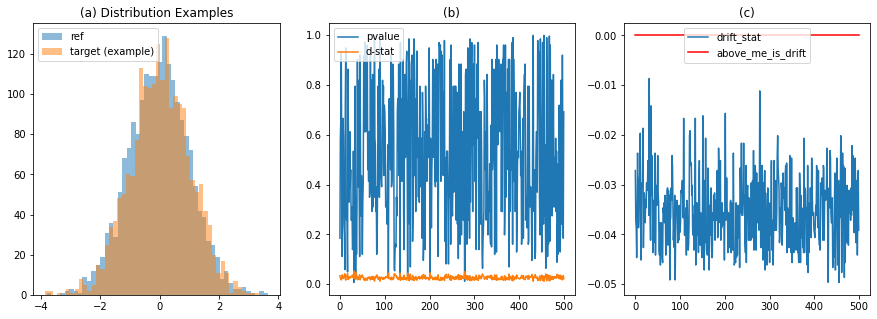

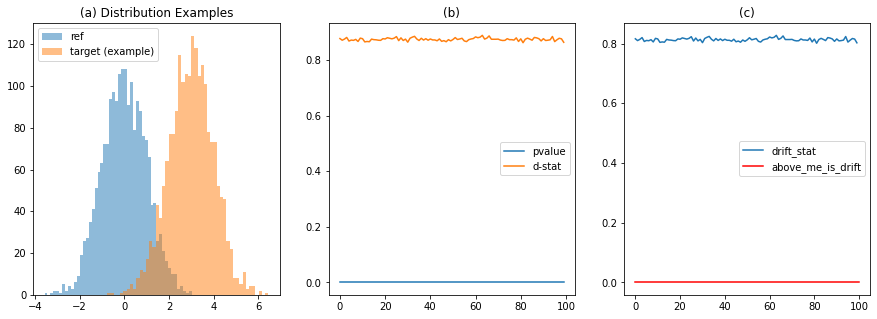

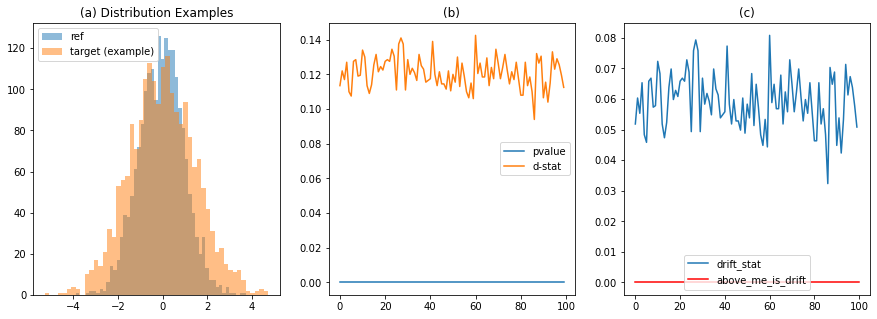

In [278]:
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from scipy.stats import ks_2samp
from numpy.random import randn
from numpy.random import lognormal

alphas = {
    100: 1.22,
    50: 1.36,
    25: 1.48,
    10: 1.63,
    5: 1.73,
    1: 1.95
}

def calc_critical_value(n1, n2, alpha=100):
    if n2 == 0:
        return None
    ca = alphas[alpha]
    return ca*np.sqrt((n1+n2)/(n1*n2))


def ks_2samp_test(ref_dist=randn, target_dist=randn, num_samples = 2000, num_trials=100):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ref = randn(num_samples)
    ax1.set_title("(a) Distribution Examples")
    ax1.hist(ref, alpha=0.5, label='ref', bins=50)
    ax1.hist(target_dist(num_samples), alpha=.5, label='target (example)', bins=50)
    ax1.legend()

    crt = calc_critical_value(num_samples, num_samples, alpha=1)
    vals = [ks_2samp(ref, target_dist(num_samples), mode="auto") for _ in range(num_trials)]
    dstat, pvals = zip(*vals)
    is_drift = [d-crt for d in dstat]
    ax2.set_title("(b)")
    ax3.set_title("(c)")
    ax2.plot(pvals, label='pvalue')
    ax2.plot(dstat, label='d-stat')
    ax3.plot(is_drift, label='drift_stat')
    ax3.plot([0, num_trials], [0, 0], 'r', label='above_me_is_drift')
    ax2.legend()
    ax3.legend()

ks_2samp_test(num_trials=500)
ks_2samp_test(target_dist=lambda n: randn(n)+3)
ks_2samp_test(target_dist=lambda n: randn(n)*1.5)